In [1]:
%reload_ext autoreload
%autoreload 2

import pickle

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
DATA_DIR = '../data/estimates'

In [3]:
run_names = [f'field_{fm}' for fm in ['AH', 'AHgamma0p8', 'BH', 'JF']]

plot_datas = {run_name : pickle.load(open(f'{DATA_DIR}/{run_name}.p', 'rb')) \
              for run_name in run_names}

In [7]:
plot_options = {
    'field_AH' : dict(c='C0'),
    'field_AHgamma0p8' : dict(c='C0', ls='-.'),
    'field_BH' : dict(c='C1'),
    'field_JF' : dict(c='C2'),
}

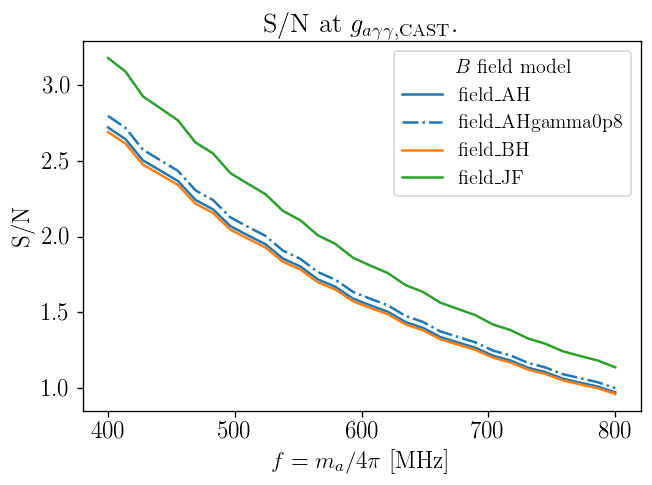

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['C0', 'C1', 'C2', 'C0']
styles = ['-', '-', '-', '-.']

for i, (n, d) in enumerate(plot_datas.items()):
    ax.plot(d['freq'], d['SNR'], label=n, **plot_options[n])
    
ax.set(xlabel=r'$f=m_a/4\pi$ [MHz]', ylabel='S/N',
       title=r'S/N at $g_{a\gamma\gamma,\mathrm{CAST}}$.')
ax.legend(title=r'$B$ field model');